In [1]:
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import scipy.ndimage as scn
import scipy.interpolate as sci
import scipy.optimize as sco

from jax.config import config
import jax
import jax.numpy as jnp

import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp

import numpyro
numpyro.enable_x64()
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import sys
sys.path.append('../')
sys.path.append('/mnt/home/ktavangar/projects/stream-membership')
sys.path.append('/mnt/home/ktavangar/projects/cats')

In [2]:
from stream_membership import SplineDensityMixtureModel
# from gd1_helpers.membership import GD1BackgroundModel, GD1StreamModel

In [3]:
gd1_tbl = at.Table.read("/mnt/home/apricewhelan/projects/gd1-dr3/data/tmp/gd1-gaiadr3-blog.fits")

# We will apply one additional selection criteria to limit the number of stars we have to handle:
gd1_tbl = gd1_tbl[(gd1_tbl["gd1_phi2"] > -7) & (gd1_tbl["gd1_phi2"] < 5)]

In [4]:
gd1_data = {
    "phi1": gd1_tbl["gd1_phi1"].astype(np.float64),
    "phi2": gd1_tbl["gd1_phi2"].astype(np.float64),
}

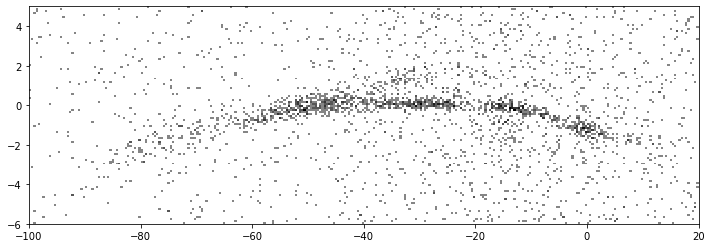

In [5]:
plt.figure(figsize=(12, 4))
plt.hist2d(
    gd1_data["phi1"],
    gd1_data["phi2"],
    bins=(np.arange(-100, 20+1e-3, 0.4),
          np.arange(-6, 5+1e-3, 0.1)),
    norm=mpl.colors.LogNorm(1e-1),
    cmap="Greys"
);

## Background model

In [6]:
from gd1_helpers.membership.gd1_model import (
    SplineDensityModelBase,
    _get_knots,
    phi1_lim,
)


class GD1ComponentBase:
    coord_names = ("phi2", )
    coord_bounds = {"phi1": (-100, 20), "phi2": (-7, 5)}

    default_grids = {
        "phi1": np.arange(*coord_bounds["phi1"], 0.2),
        "phi2": np.arange(*coord_bounds["phi2"], 0.1),
    }


class GD1BackgroundModel(GD1ComponentBase, SplineDensityModelBase):
    name = "background"

    knots = {
        "ln_n0": _get_knots(*phi1_lim, 5, arange=False),
    }
    param_bounds = {
        "ln_n0": (-5, 8),
        "phi2": {},
    }

    # spline_ks = {"ln_n0": 3}
    spline_ks = {}

    # Can probably use a lower resolution grid here?
    integration_grid_phi1 = jnp.arange(phi1_lim[0], phi1_lim[1] + 1e-3, 0.1)

    @classmethod
    def setup_numpyro(cls, data=None):
        pars = {}

        # ln_n0 : linear density
        pars["ln_n0"] = numpyro.sample(
            f"ln_n0_{cls.name}",
            dist.Uniform(*cls.param_bounds["ln_n0"]),
            sample_shape=(len(cls.knots["ln_n0"]),),
        )

        return cls(pars=pars, data=data)

    def get_dists(self, data):
        dists = {}

        if "phi2" in self.coord_names:
            dists["phi2"] = dist.Uniform(-7, jnp.full(len(data["phi1"]), 5))

        return dists

    def extra_ln_prior(self):
        lp = 0.0

        lp += (
            dist.Normal(0, 0.5)
            .log_prob(self.splines["ln_n0"]._y[1:] - self.splines["ln_n0"]._y[:-1])
            .sum()
        )

        return lp

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [7]:
prior = Predictive(GD1BackgroundModel.setup_numpyro, num_samples=16)
bkg_prior_samples = prior(jax.random.PRNGKey(42))
bkg_prior_samples

{'ln_n0_background': Array([[-2.34131805,  3.99600865,  1.06034084,  0.42590288, -2.02644645],
        [ 5.92989557,  7.60351618,  1.18743957,  5.72864736,  7.18448443],
        [ 1.01073716, -0.49328403,  0.09197245,  1.75667729,  7.1135976 ],
        [-0.73386984, -0.36268358,  4.80764054, -2.45942676,  7.5705223 ],
        [-0.89193532,  0.18033976,  1.48717173,  4.01533191,  7.69086726],
        [ 0.50453947, -2.1506585 , -1.53050495, -3.37948125,  5.26937474],
        [ 6.43531161,  7.72405191,  7.07280967, -1.47768634, -3.47987249],
        [ 4.52743572, -1.71075962,  4.06844974,  7.9669043 , -0.83033976],
        [ 1.59216166, -4.51868418,  6.00873394, -3.43168576, -1.47859692],
        [ 6.52749084, -2.35723966, -3.8358303 ,  5.22910464,  6.26324407],
        [-3.16913611, -4.25425632,  7.62809375,  4.75341578,  5.73546975],
        [-0.98629265,  6.0722115 , -4.53652798,  2.34500017,  5.04351147],
        [ 1.77170407,  5.85672035, -4.62639708,  2.35759416, -3.16714089],
     

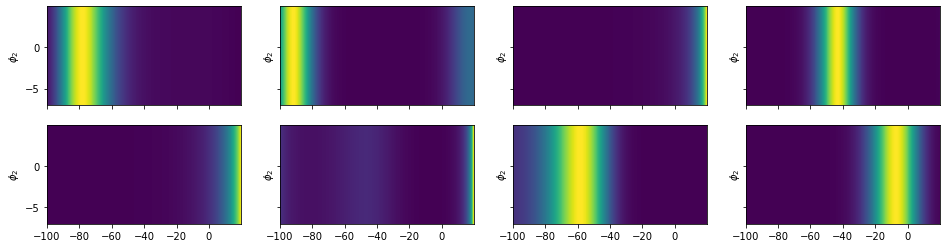

In [8]:
fig, axes = plt.subplots(2, 4, figsize=(16, 4), sharex=True, sharey=True)
for i in range(8):
    ax = axes.flat[i]
    background_prior_pars = GD1BackgroundModel.unpack_params(
        {k: v[i] for k, v in bkg_prior_samples.items()}
    )
    background = GD1BackgroundModel(background_prior_pars)
    background.ln_likelihood(gd1_data)
    background.plot_model_projections(axes=ax)


## Stream model

In [9]:
class GD1StreamModel(GD1ComponentBase, SplineDensityModelBase):
    name = "stream"

    knots = {
        "ln_n0": _get_knots(*phi1_lim, 4.0),
        "phi2": _get_knots(*phi1_lim, 6.0),
    }

    param_bounds = {
        "ln_n0": (-5, 8),
        "phi2": {"mean": GD1ComponentBase.coord_bounds["phi2"], "ln_std": (-2, 0.5)}
    }

    integration_grid_phi1 = jnp.arange(phi1_lim[0], phi1_lim[1] + 1e-3, 0.2)

    @classmethod
    def setup_numpyro(cls, data=None):
        pars = {}

        # ln_n0 : linear density
        pars["ln_n0"] = numpyro.sample(
            f"ln_n0_{cls.name}",
            dist.Uniform(*cls.param_bounds["ln_n0"]),
            sample_shape=(len(cls.knots["ln_n0"]),),
        )

        # Other coordinates:
        for coord_name in cls.coord_names:
            pars[coord_name] = {}
            for par_name in ["mean", "ln_std"]:
                pars[coord_name][par_name] = numpyro.sample(
                    f"{coord_name}_{par_name}_{cls.name}",
                    dist.Uniform(*cls.param_bounds[coord_name][par_name]),
                    sample_shape=(len(cls.knots[coord_name]),),
                )

        return cls(pars=pars, data=data)

    def get_dists(self, data):
        dists = {}
        dists["ln_n0"] = self.splines["ln_n0"]
        if "phi2" in self.coord_names:
            dists["phi2"] = dist.TruncatedNormal(
                loc=self.splines["phi2"]["mean"](data["phi1"]),
                scale=jnp.exp(self.splines["phi2"]["ln_std"](data["phi1"])),
                low=self.coord_bounds["phi2"][0],
                high=self.coord_bounds["phi2"][1],
            )
        return dists

    def extra_ln_prior(self):
        lp = 0.0

        lp += (
            dist.Normal(0, 0.25)
            .log_prob(self.splines["ln_n0"]._y[1:] - self.splines["ln_n0"]._y[:-1])
            .sum()
        )

        #Updates to make: ln_std should come from galstreams width
        #                 mean should come from galstreams track
        std_map = {"mean": 0.5, "ln_std": 0.1, "_w_": 0.1}
        for coord_name in self.coord_names:
            for par_name in self.splines[coord_name]:
                for check in ["mean", "ln_std", "_w_"]:
                    if check in par_name:
                        std = std_map[check]
                        break
                else:
                    std = 1.0

                spl_y = self.splines[coord_name][par_name]._y
                lp += dist.Normal(0, std).log_prob(spl_y[1:] - spl_y[:-1]).sum()

        return lp

In [10]:
prior = Predictive(GD1StreamModel.setup_numpyro, num_samples=16)
stream_prior_samples = prior(jax.random.PRNGKey(42))
stream_prior_samples

{'ln_n0_stream': Array([[ 7.03022503e+00, -3.45246965e-01, -1.54753993e+00,
          5.74999766e+00,  9.61797607e-01, -1.58862198e+00,
         -2.81528154e+00,  6.22818470e+00, -2.72347332e+00,
          3.15648629e+00,  2.26156493e+00, -1.36684161e+00,
          7.04150193e+00, -4.69538956e+00, -3.20896080e+00,
          5.49546260e+00, -4.74513092e+00,  5.10335152e+00,
          7.86114253e-01,  7.84495358e+00, -6.93230130e-01,
         -1.42759432e+00,  7.56515353e+00,  5.05810202e+00,
         -4.84324877e+00,  3.97650857e+00,  4.67473432e-01,
          5.97170138e+00, -4.51685138e+00,  1.96135155e+00,
          1.16976893e-01, -1.09271614e+00,  2.42734177e+00,
         -2.79368264e+00,  6.16301399e+00],
        [-1.86168994e+00,  6.43288630e+00,  5.08846850e+00,
          3.61475519e-01,  5.64063198e+00,  1.25030516e+00,
          2.67885281e+00,  4.89979774e+00,  5.26366482e+00,
          7.95977004e+00,  7.04572189e-01,  4.34055985e+00,
          3.81597856e+00,  7.14635895e+0

In [11]:
stream_prior_pars = GD1StreamModel.unpack_params(
        {k: v[i] for k, v in stream_prior_samples.items()}
    )
stream = GD1StreamModel(stream_prior_pars)
stream.extra_ln_prior()

Array(-10549.97929532, dtype=float64)

In [12]:
stream.splines

{'ln_n0': <jax_cosmo.scipy.interpolate.InterpolatedUnivariateSpline at 0x155315139fd0>,
 'phi2': {'ln_std': <jax_cosmo.scipy.interpolate.InterpolatedUnivariateSpline at 0x15520013c940>,
  'mean': <jax_cosmo.scipy.interpolate.InterpolatedUnivariateSpline at 0x155100127190>}}

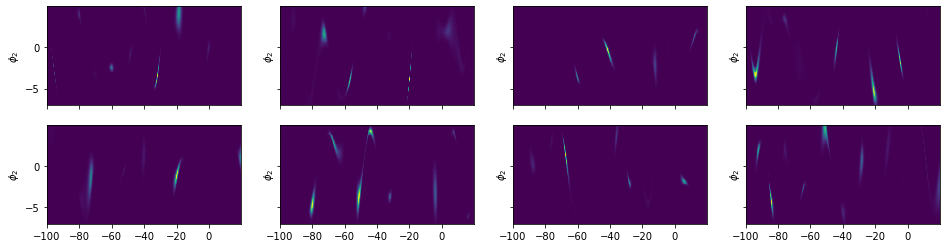

In [13]:
fig, axes = plt.subplots(2, 4, figsize=(16, 4), sharex=True, sharey=True)
for i in range(8):
    ax = axes.flat[i]
    stream_prior_pars = GD1StreamModel.unpack_params(
        {k: v[i] for k, v in stream_prior_samples.items()}
    )
    stream = GD1StreamModel(stream_prior_pars)
    ll = stream.ln_likelihood(gd1_data)  # testing that the likelihood evaluation works
    assert np.isfinite(ll).all()
    stream.plot_model_projections(axes=ax)


## Mixture model

In [14]:
# def custom_model(data=None):
#     knots = {
#         "ln_n0_stream": jnp.linspace()
#     }
    
#     ln_n0_stream = numpyro.sample(
#         "ln_n0_stream",
#         dist.Uniform(-8, 8),
#         sample_shape=(len(knots["ln_n0"]),),
#     )
    
#     if data is not None:
#         # Compute the log of the effective volume integral, used in the poisson
#         # process likelihood
#         ln_Vs = jnp.array([c.get_ln_V() for c in components])
#         ln_ns = jnp.array([c.ln_number_density(data) for c in components])
#         numpyro.factor(f"V", -jnp.exp(logsumexp(ln_Vs, axis=0)))
#         numpyro.factor(f"ln_n", logsumexp(ln_ns, axis=0).sum())

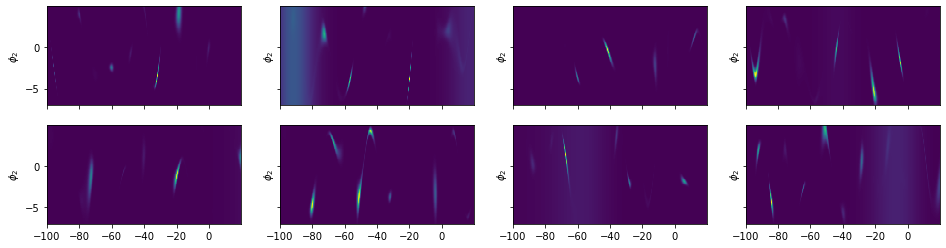

In [15]:
fig, axes = plt.subplots(2, 4, figsize=(16, 4), sharex=True, sharey=True)
for i in range(8):
    ax = axes.flat[i]
    
    background_prior_pars = GD1BackgroundModel.unpack_params(
        {k: v[i] for k, v in bkg_prior_samples.items()}
    )
    background = GD1BackgroundModel(background_prior_pars)
    
    stream_prior_pars = GD1StreamModel.unpack_params(
        {k: v[i] for k, v in stream_prior_samples.items()}
    )
    stream = GD1StreamModel(stream_prior_pars)
    
    mixture_model = SplineDensityMixtureModel([background, stream])
    ll = mixture_model.ln_likelihood(gd1_data)  # testing that the likelihood evaluation works
    assert np.isfinite(ll).all()

    mixture_model.plot_model_projections(axes=ax)

In [16]:
# mixture_model.get_dists(gd1_data)
# pars = {
#     'background': background_prior_pars,
#     'stream': stream_prior_pars
# }
# grids, vals = mixture_model.evaluate_on_grids(pars)

# Initialization:

In [17]:
# from scipy.ndimage import gaussian_filter1d

# H, xe, ye = np.histogram2d(
#     gd1_tbl["gd1_phi1"],
#     gd1_tbl["gd1_phi2"],
#     bins=(np.linspace(-90, 20 + 1e-3, 11), np.arange(-7, 5 + 1e-3, 0.2)),
# )
# xc = 0.5 * (xe[:-1] + xe[1:])
# yc = 0.5 * (ye[:-1] + ye[1:])

# H = gaussian_filter1d(H, sigma=1)
# H -= np.mean(H[:, (yc < -5) | (yc > 3)])

# H /= (xe[1] - xe[0]) / 12
# H_density = H.copy()

# peak_idx = H.argmax(axis=1)
# H /= H[np.arange(H.shape[0]), peak_idx][:, None]
# H_ln_density = np.log(H_density[np.arange(H.shape[0]), peak_idx])


# fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True, constrained_layout=True)
# cs = axes[0].pcolormesh(xe, ye, H.T, vmin=0, vmax=1, cmap="Greys")
# axes[0].plot(xc, yc[peak_idx], color="tab:red")
# axes[0].set_ylabel(r"$\phi_2$")
# axes[1].plot(xc, H_ln_density)
# axes[1].set_ylabel(r"log-density")
# axes[1].set_xlabel(r"$\phi_1$")

### Galstreams Initialization

Some of this is taken directly from cats code.

In [18]:
import cats

from cats.pawprint.pawprint import Pawprint, Footprint2D
from cats.cmd.CMD import Isochrone
from cats.inputs import stream_inputs as inputs
from cats.proper_motions import ProperMotionSelection, rough_pm_poly

Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


In [19]:
import os
import galstreams as gst

stream_name = 'GD-1'
pawprint_ID = 'pricewhelan2018'

galstreams_dir = os.path.dirname(gst.__file__)
galstreams_tracks = os.path.join(galstreams_dir, "tracks/")

def _make_track_file_name(stream_name, pawprint_ID):
    return (
        galstreams_tracks
        + "track.st."
        + stream_name
        + "."
        + pawprint_ID
        + ".ecsv"
    )

def _make_summary_file_name(stream_name, pawprint_ID):
    return (
        galstreams_tracks
        + "track.st."
        + stream_name
        + "."
        + pawprint_ID
        + ".summary.ecsv"
    )

track_file = _make_track_file_name(stream_name, pawprint_ID)
summary_file = _make_summary_file_name(stream_name, pawprint_ID)

gd1_track_gst = gst.Track6D(stream_name=stream_name,
                            track_name=pawprint_ID,
                            track_file=track_file,
                            summary_file=summary_file,
                        )

gd1_track_gst.stream_frame
track = gd1_track_gst.track.transform_to(gd1_track_gst.stream_frame)

In [20]:
init_mean_phi2 = sci.InterpolatedUnivariateSpline(track.phi1, track.phi2, k=1)(
    GD1StreamModel.knots["phi2"])


# init_mean_pm_phi1_cosphi2 = sci.InterpolatedUnivariateSpline(track.phi1, track.pm_phi1_cosphi2, k=1)(
#     GD1StreamModel.knots["pm_phi1_cosphi2"])

# init_mean_pm_phi2 = sci.InterpolatedUnivariateSpline(track.phi1, track.pm_phi2, k=1)(
#     GD1StreamModel.knots["pm_phi2"])

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


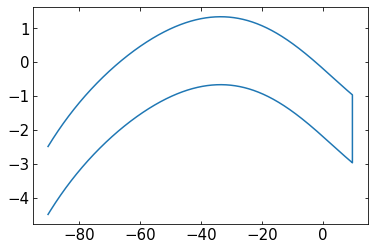

In [21]:
plt.plot(gd1_track_gst.create_sky_polygon_footprint_from_track(width=2*u.deg).phi1, gd1_track_gst.create_sky_polygon_footprint_from_track(width=2*u.deg).phi2)

In [22]:
# Building Sky Mask

stream='GD-1'
fn = "/mnt/home/ktavangar/projects/gd1-dr3/data/joined-{}.fits".format(inputs[stream]['short_name'])
cat = at.Table.read(fn)


##########################################################################
# Whatever cuts we make before we run the model. Doesn't have to be this

p = Pawprint.pawprint_from_galstreams(inputs[stream]['short_name'],
                                      inputs[stream]['pawprint_id'],
                                      width=inputs[stream]['width'] * u.deg)

# rough pm cut to start with (this comes only from the galstreams proper motion tracks)
p.pmprint, rough_pm_mask = rough_pm_poly(p, cat, buffer=2) # wider cut than in the stream density initialization

# Create the CMD cuts
o = Isochrone(stream, cat, pawprint=p)
_, iso_mask, _, hb_mask, pprint = o.simpleSln(maxmag=22, mass_thresh=0.83)

data = o.cat[rough_pm_mask & (iso_mask | hb_mask)]
############################################################################
print('Finished Cutting')


sky_poly = np.array([gd1_track_gst.create_sky_polygon_footprint_from_track(width=2*u.deg).phi1, 
                    gd1_track_gst.create_sky_polygon_footprint_from_track(width=2*u.deg).phi2]).T

off_track_poly = np.array([gd1_track_gst.create_sky_polygon_footprint_from_track(width=2*u.deg).phi1, 
                            gd1_track_gst.create_sky_polygon_footprint_from_track(width=2*u.deg).phi2 - 3*u.deg]).T

on_poly_patch = mpl.patches.Polygon(sky_poly, facecolor="none", edgecolor="k", linewidth=2
)
off_poly_patch = mpl.patches.Polygon(off_track_poly, facecolor="none", edgecolor="k", linewidth=2
)

print('Making masks')
points = np.vstack((data["phi1"], data["phi2"])).T
on_mask = on_poly_patch.get_path().contains_points(points)
off_mask = off_poly_patch.get_path().contains_points(points)
bkg_mask = ~on_mask

Finished Cutting
Making masks


Text(0.5, 0, '$\\phi_1$')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


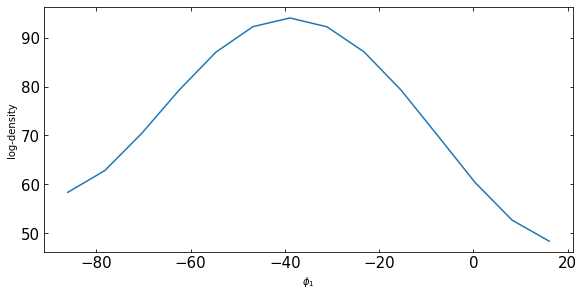

In [23]:
# Background Density

H_bkg, xe = np.histogram(data["phi1"][bkg_mask], bins=np.linspace(-90, 20 + 1e-20, 15))

xc_bkg = 0.5 * (xe[:-1] + xe[1:])

dx = xe[1] - xe[0]
H_bkg = scn.gaussian_filter1d(H_bkg, sigma=2) / dx / 4

fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)
ax.plot(xc_bkg, H_bkg)
ax.set_ylabel(r"log-density")
ax.set_xlabel(r"$\phi_1$")

### Stream Density Initialization

In [24]:
# rough pm cut to start with (this comes only from the galstreams proper motion tracks)
p.pmprint, rough_pm_mask = rough_pm_poly(p, data, buffer=0.5)

# Create the CMD cuts
o = Isochrone(stream, data, pawprint=p)
_, iso_mask, _, hb_mask, pprint = o.simpleSln(maxmag=22, mass_thresh=0.83)

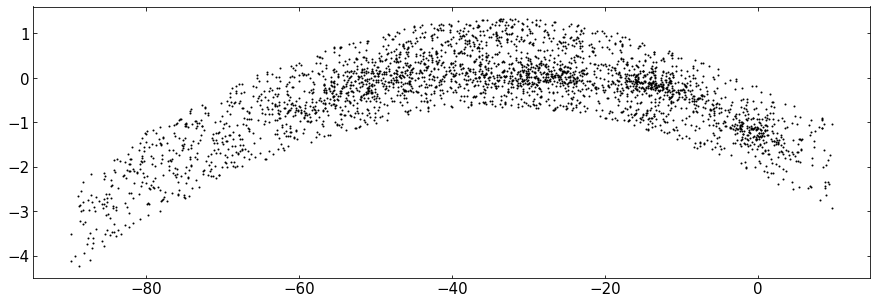

In [25]:
plt.figure(figsize=(15,5))
plt.scatter(o.cat[rough_pm_mask & (iso_mask | hb_mask) & on_mask]['phi1'], 
            o.cat[rough_pm_mask & (iso_mask | hb_mask) & on_mask]['phi2'], s=1, c='k')
plt.show()

Text(0.5, 0, '$\\phi_1$')

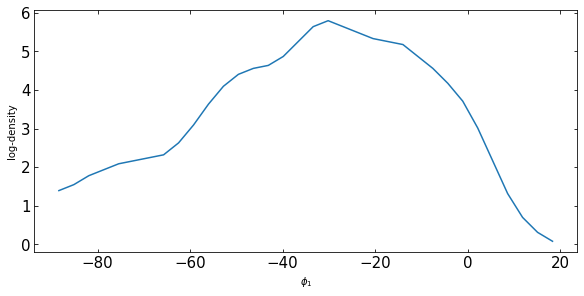

In [26]:
# Stream Density

# STEPS to implement:
# Use the cats infrastructure to get make a rough-ish proper motion cut and CMD cut 
#  (it doesn't need to be complete so less rough than in eactual cats polygons)
# With the dataset from that, take the onstream section from before and 
#  make a density map using the histogram method below based on that
H_stream, xe = np.histogram(o.cat[rough_pm_mask & (iso_mask | hb_mask) & on_mask]['phi1'], 
                     bins=np.linspace(-90, 20 + 1e-3, 35))
H_off, xe_off = np.histogram(o.cat[rough_pm_mask & (iso_mask | hb_mask) & off_mask]['phi1'], 
                             bins=np.linspace(-90, 20 + 1e-3, 35))

xc_stream = 0.5 * (xe[:-1] + xe[1:])

dx = xe[1] - xe[0]
H_stream = scn.gaussian_filter1d(H_stream-H_off, sigma=2) / dx / 4

fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)
ax.plot(xc_stream, H_stream)
ax.set_ylabel(r"log-density")
ax.set_xlabel(r"$\phi_1$")

In [27]:
init_mean_phi2 = sci.InterpolatedUnivariateSpline(track.phi1, track.phi2, k=1)(
    GD1StreamModel.knots["phi2"])


# init_mean_pm_phi1_cosphi2 = sci.InterpolatedUnivariateSpline(track.phi1, track.pm_phi1_cosphi2, k=1)(
#     GD1StreamModel.knots["pm_phi1_cosphi2"])

# init_mean_pm_phi2 = sci.InterpolatedUnivariateSpline(track.phi1, track.pm_phi2, k=1)(
#     GD1StreamModel.knots["pm_phi2"])

init_ln_n0 = sci.InterpolatedUnivariateSpline(xc_stream, np.log(H_stream), k=1)(GD1StreamModel.knots["ln_n0"])

init_ln_n0_bkg = sci.InterpolatedUnivariateSpline(xc_bkg, np.log(H_bkg), k=1)(GD1BackgroundModel.knots['ln_n0'])

In [28]:
init_pars = {
    "stream": {
        "ln_n0": init_ln_n0,
        "phi2": {
            "mean": init_mean_phi2,
            "ln_std": np.full_like(init_mean_phi2, -0.75)
        }
    },
    "background": {
        "ln_n0": init_ln_n0_bkg,
    }
}

Components = [GD1StreamModel, GD1BackgroundModel]
init_pars["stream"] = GD1StreamModel.clip_params(init_pars["stream"])
init_pars["background"] = GD1BackgroundModel.clip_params(init_pars["background"])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(<Figure size 864x432 with 4 Axes>,
 array([[<AxesSubplot:title={'center':'stream'}, ylabel='ln_n0'>,
         <AxesSubplot:title={'center':'background'}, ylabel='ln_n0'>],
        [<AxesSubplot:ylabel='phi2'>, <AxesSubplot:ylabel='phi2'>]],
       dtype=object))

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


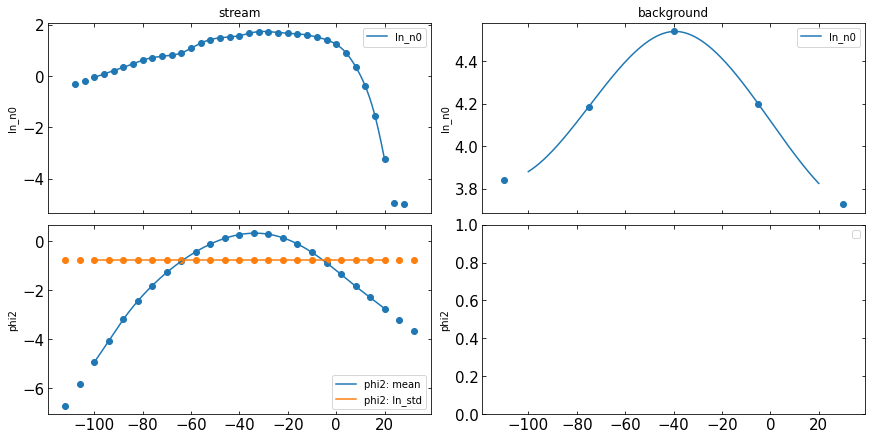

In [29]:
init_mixture = SplineDensityMixtureModel([C(init_pars[C.name]) for C in Components])
init_mixture.plot_knots()

In [30]:
Components = [GD1BackgroundModel, GD1StreamModel]

In [33]:
import jaxopt

optimizer = jaxopt.ScipyBoundedMinimize(
    "l-bfgs-b",
    fun=lambda p, data: SplineDensityMixtureModel.objective(
        p, data=data, Components=Components
    ),
    options=dict(maxls=10000),
    maxiter=100_000,
)
opt_res = optimizer.run(
    init_params=init_pars,
    data=gd1_data,
    bounds=SplineDensityMixtureModel._get_jaxopt_bounds(Components),
)
mix_opt_pars = opt_res.params
opt_res.state


ScipyMinimizeInfo(fun_val=Array(-0.44482641, dtype=float64, weak_type=True), success=True, status=0, iter_num=921, hess_inv=LbfgsInvHessProduct(sk=[[-1.02869604e-04  1.43124218e-04  5.18374723e-06 -1.05993263e-06
  -3.67575156e-05  4.26355746e-05 -3.41084597e-04 -8.72621715e-05
   1.59807542e-05 -2.60181554e-04 -5.60017430e-05  2.77585879e-05
   6.56860521e-05 -1.16163179e-04  4.57184190e-05  1.12646179e-04
   2.85452717e-05  4.97795174e-05  6.56220912e-05  2.60826557e-05
   1.87517058e-05 -4.72633147e-05 -3.68533390e-05  2.66219315e-05
  -5.62483820e-05 -1.05988739e-04  2.19175783e-05 -4.90105541e-05
   6.76770696e-05 -5.58073962e-05 -2.17307586e-05  2.57371946e-05
   7.74659124e-05 -2.63319004e-05 -1.13052582e-04  9.68714862e-05
   3.75970666e-04 -2.54034931e-04  2.73635517e-04  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -1.02966760e-04  2.64150792e-05 -1.16157727e-04  2.67442199e-05
  -5.58303978e-06  2.17860521e-05  5.00412239e-05 -3.40595623

In [34]:
opt_mixture = SplineDensityMixtureModel([
    GD1BackgroundModel(mix_opt_pars['background']), 
    GD1StreamModel(mix_opt_pars['stream'])
])

(<Figure size 720x288 with 1 Axes>,
 array([<AxesSubplot:ylabel='$\\phi_2$'>], dtype=object))

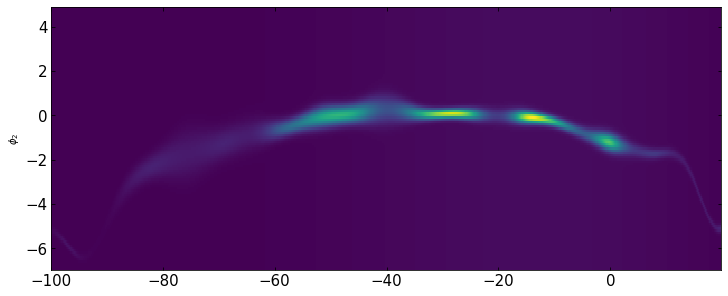

In [35]:
opt_mixture.plot_model_projections()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(<Figure size 864x432 with 4 Axes>,
 array([[<AxesSubplot:title={'center':'background'}, ylabel='ln_n0'>,
         <AxesSubplot:title={'center':'stream'}, ylabel='ln_n0'>],
        [<AxesSubplot:ylabel='phi2'>, <AxesSubplot:ylabel='phi2'>]],
       dtype=object))

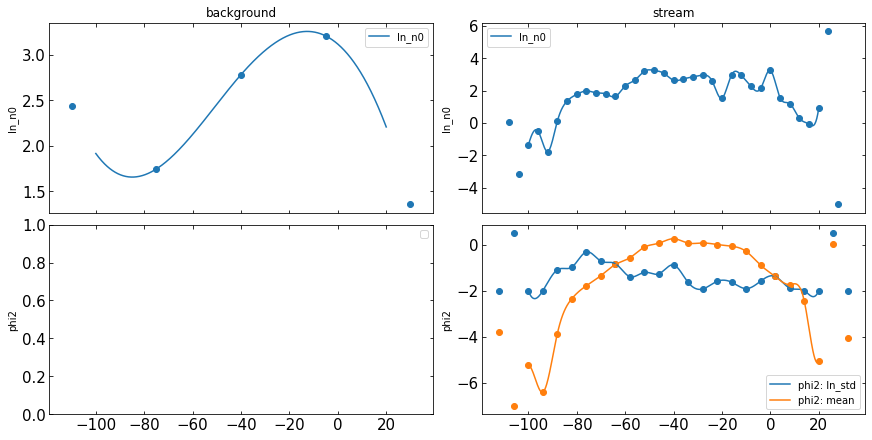

In [36]:
opt_mixture.plot_knots()

# SAMPLING BELOW

In [30]:
rng = np.random.default_rng(seed=42)

n_chains = 4

init_pars_chains = {}
for C in Components:
    C_pars = init_pars[C.name]
    
    sub = {}
    tmp = C_pars[C.density_name]
    sub[C.density_name] = rng.normal(tmp, 1e-2, size=(n_chains, len(tmp)))
    
    for coord_name in C.coord_names:
        if coord_name not in sub:
            if coord_name not in C_pars or not C_pars[coord_name]:
                continue
            sub[coord_name] = {}
        
        for par_name, tmp in C_pars[coord_name].items():
            sub[coord_name][par_name] = rng.normal(tmp, 1e-2, size=(n_chains, len(tmp)))
    
    init_pars_chains[C.name] = sub

In [31]:
mcmc_kw = dict(
    num_warmup=100,
    num_samples=100,
    num_chains=n_chains,
    chain_method="sequential",
)

# mcmc = MCMC(NUTS(SplineDensityMixtureModel.setup_numpyro), **mcmc_kw)
# mcmc.run(
#     jax.random.PRNGKey(0), 
#     Components=Components,
#     data=gd1_data,
#     init_params=init_pars_chains
# )

mcmc = MCMC(NUTS(custom_setup), **mcmc_kw)
mcmc.run(
    jax.random.PRNGKey(0), 
    Components=Components,
    data=gd1_data,
    init_params=init_pars_chains
)

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:57<00:00,  1.71it/s, 127 steps of size 2.88e-02. acc. prob=0.89]


In [32]:
mcmc.print_summary()


                            mean       std    median      5.0%     95.0%     n_eff     r_hat
   ln_n0_background[0]      3.62      1.26      3.60      1.48      5.58    329.24      1.01
   ln_n0_background[1]      1.63      0.12      1.64      1.43      1.80    278.56      0.99
   ln_n0_background[2]      2.11      0.11      2.11      1.90      2.28    411.14      0.99
   ln_n0_background[3]      1.92      0.10      1.92      1.76      2.07    940.94      0.99
   ln_n0_background[4]      2.75      0.07      2.75      2.64      2.86    562.22      1.00
   ln_n0_background[5]      3.28      0.06      3.28      3.17      3.36    484.00      1.00
   ln_n0_background[6]      3.16      0.06      3.17      3.08      3.27    370.76      1.00
   ln_n0_background[7]      2.62      0.08      2.63      2.49      2.76    165.56      1.01
   ln_n0_background[8]      3.07      0.85      3.15      1.72      4.43    171.45      1.00
       ln_n0_stream[0]      1.85      4.01      2.03     -3.66      8

In [33]:
samples = mcmc.get_samples()
samples_unpacked = SplineDensityMixtureModel.unpack_params(samples, Components)

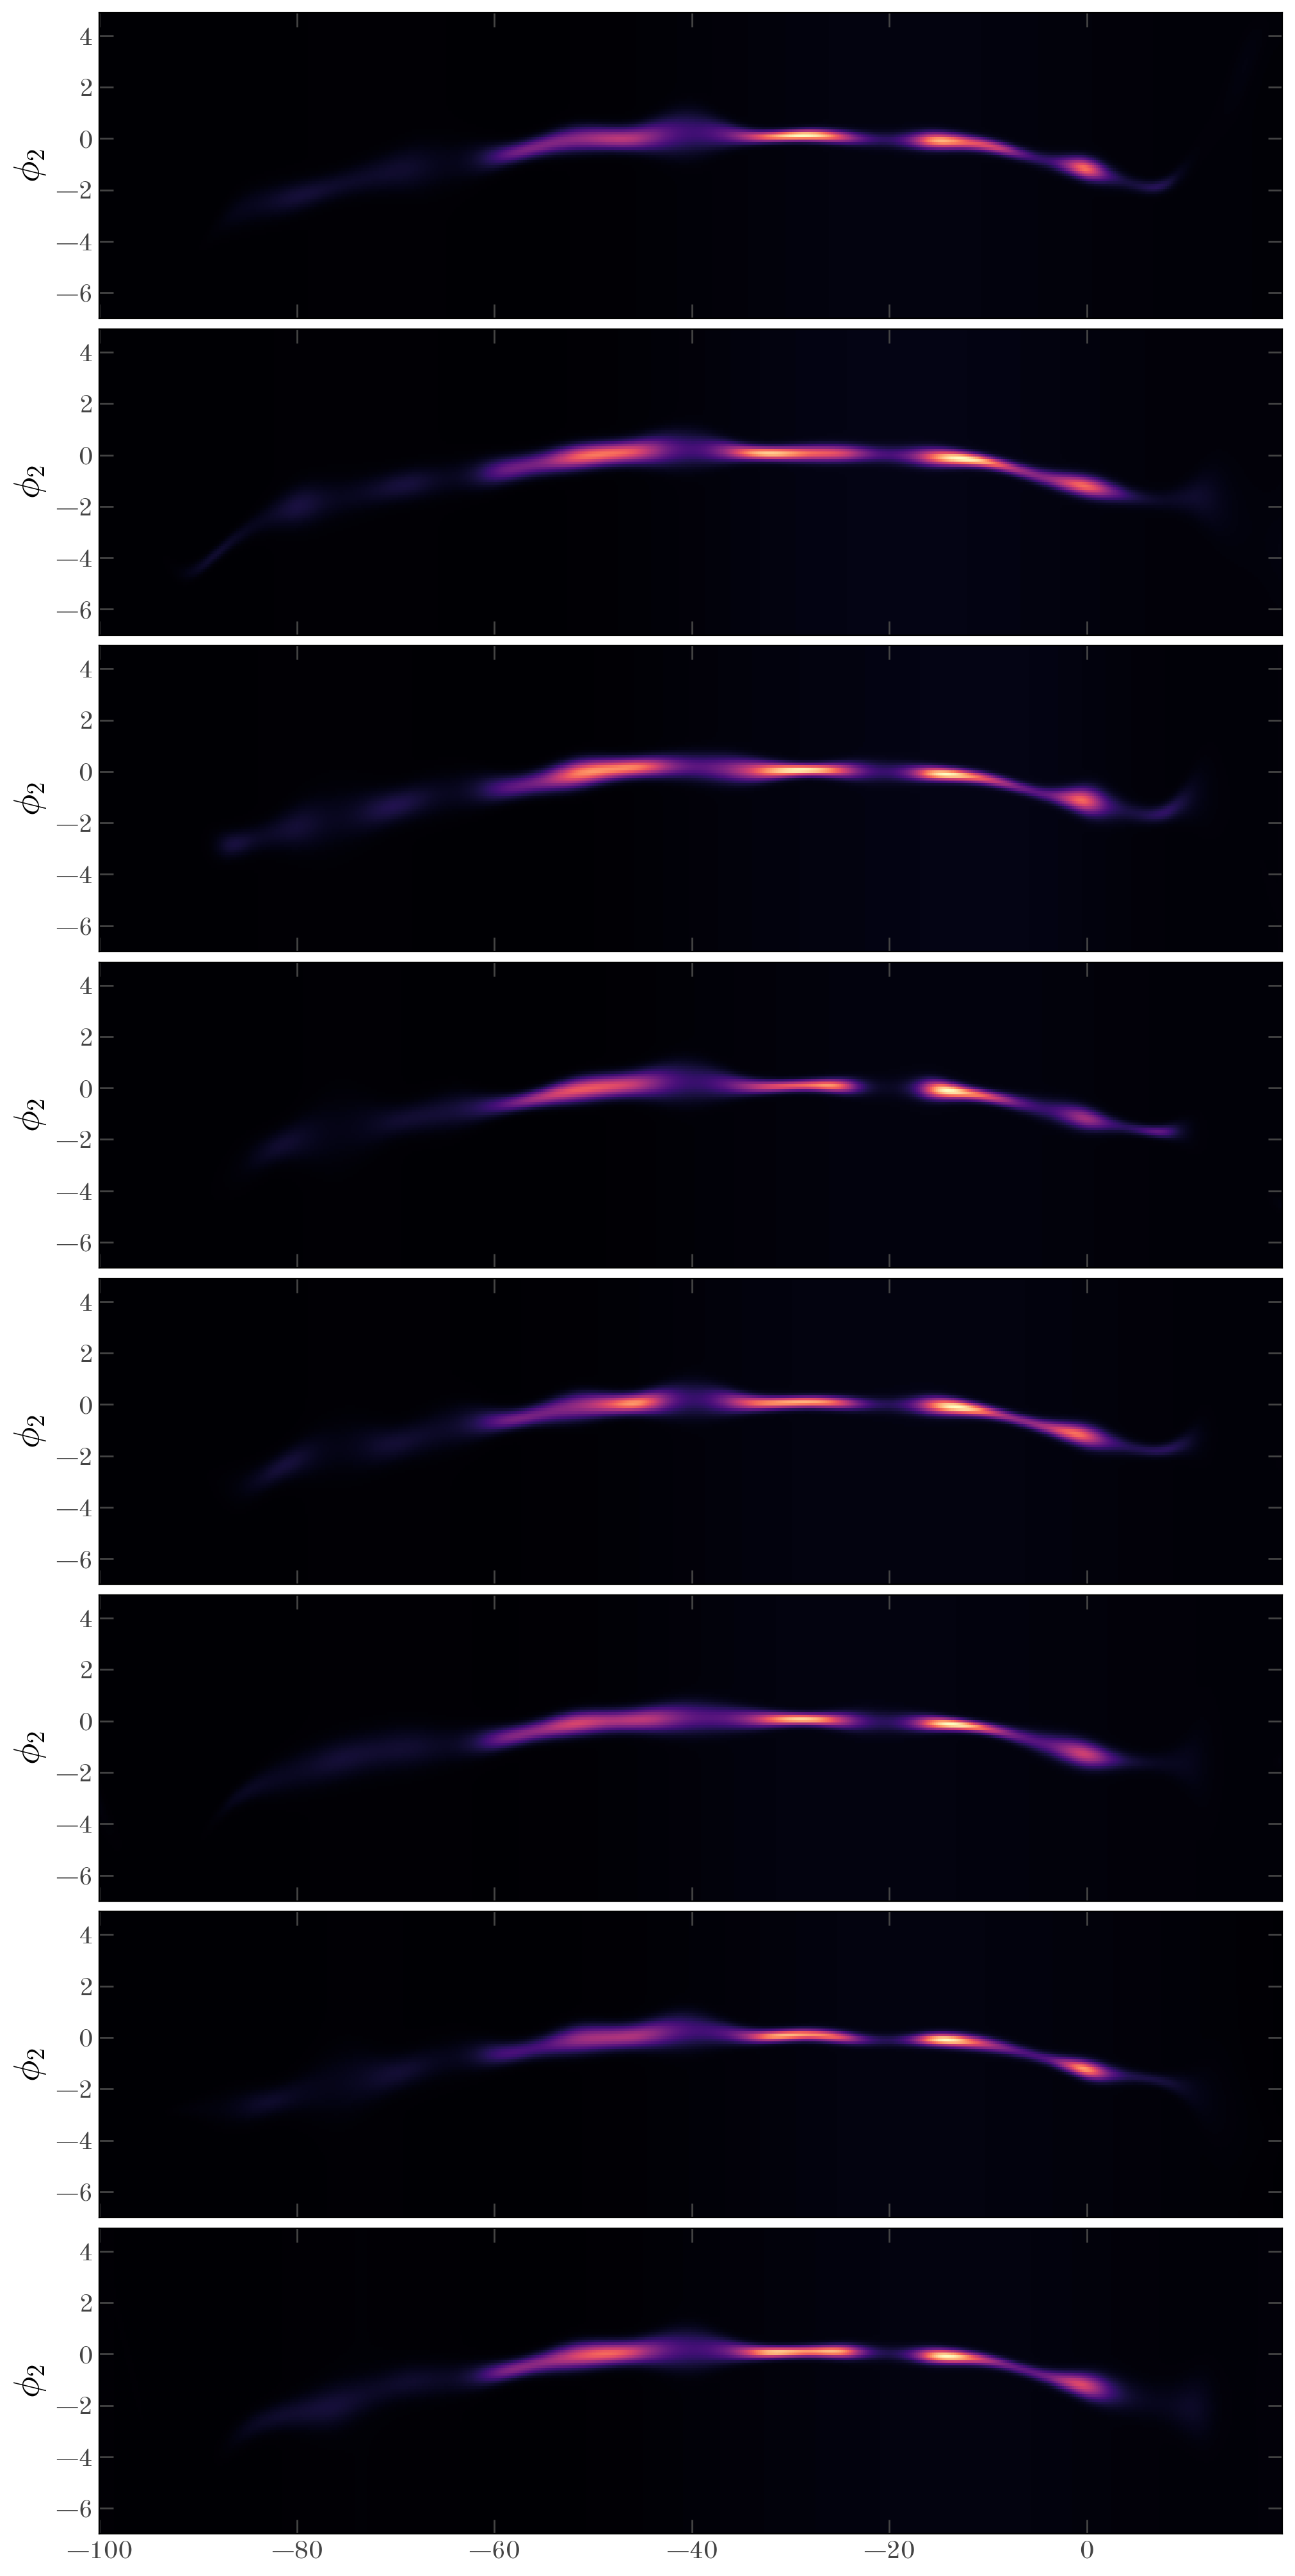

In [34]:
nsamples = 8
fig, axes = plt.subplots(
    nsamples, 1, figsize=(10, nsamples * 2.5), sharex=True, sharey=True, constrained_layout=True
)

rng = np.random.default_rng(32)
for j, i in enumerate(rng.choice(samples['ln_n0_background'].shape[0], size=nsamples)):
    sample_unpacked = SplineDensityMixtureModel.unpack_params(
        {k: v[i] for k, v in samples.items()}, 
        Components
    )
    sample_mixture = SplineDensityMixtureModel([C(sample_unpacked[C.name]) for C in Components])
    sample_mixture.plot_model_projections(axes=np.array([axes[j]]))

(<Figure size 1200x600 with 4 Axes>,
 array([[<AxesSubplot: title={'center': 'stream'}, ylabel='ln_n0'>,
         <AxesSubplot: title={'center': 'background'}, ylabel='ln_n0'>],
        [<AxesSubplot: ylabel='phi2'>, <AxesSubplot: ylabel='phi2'>]],
       dtype=object))

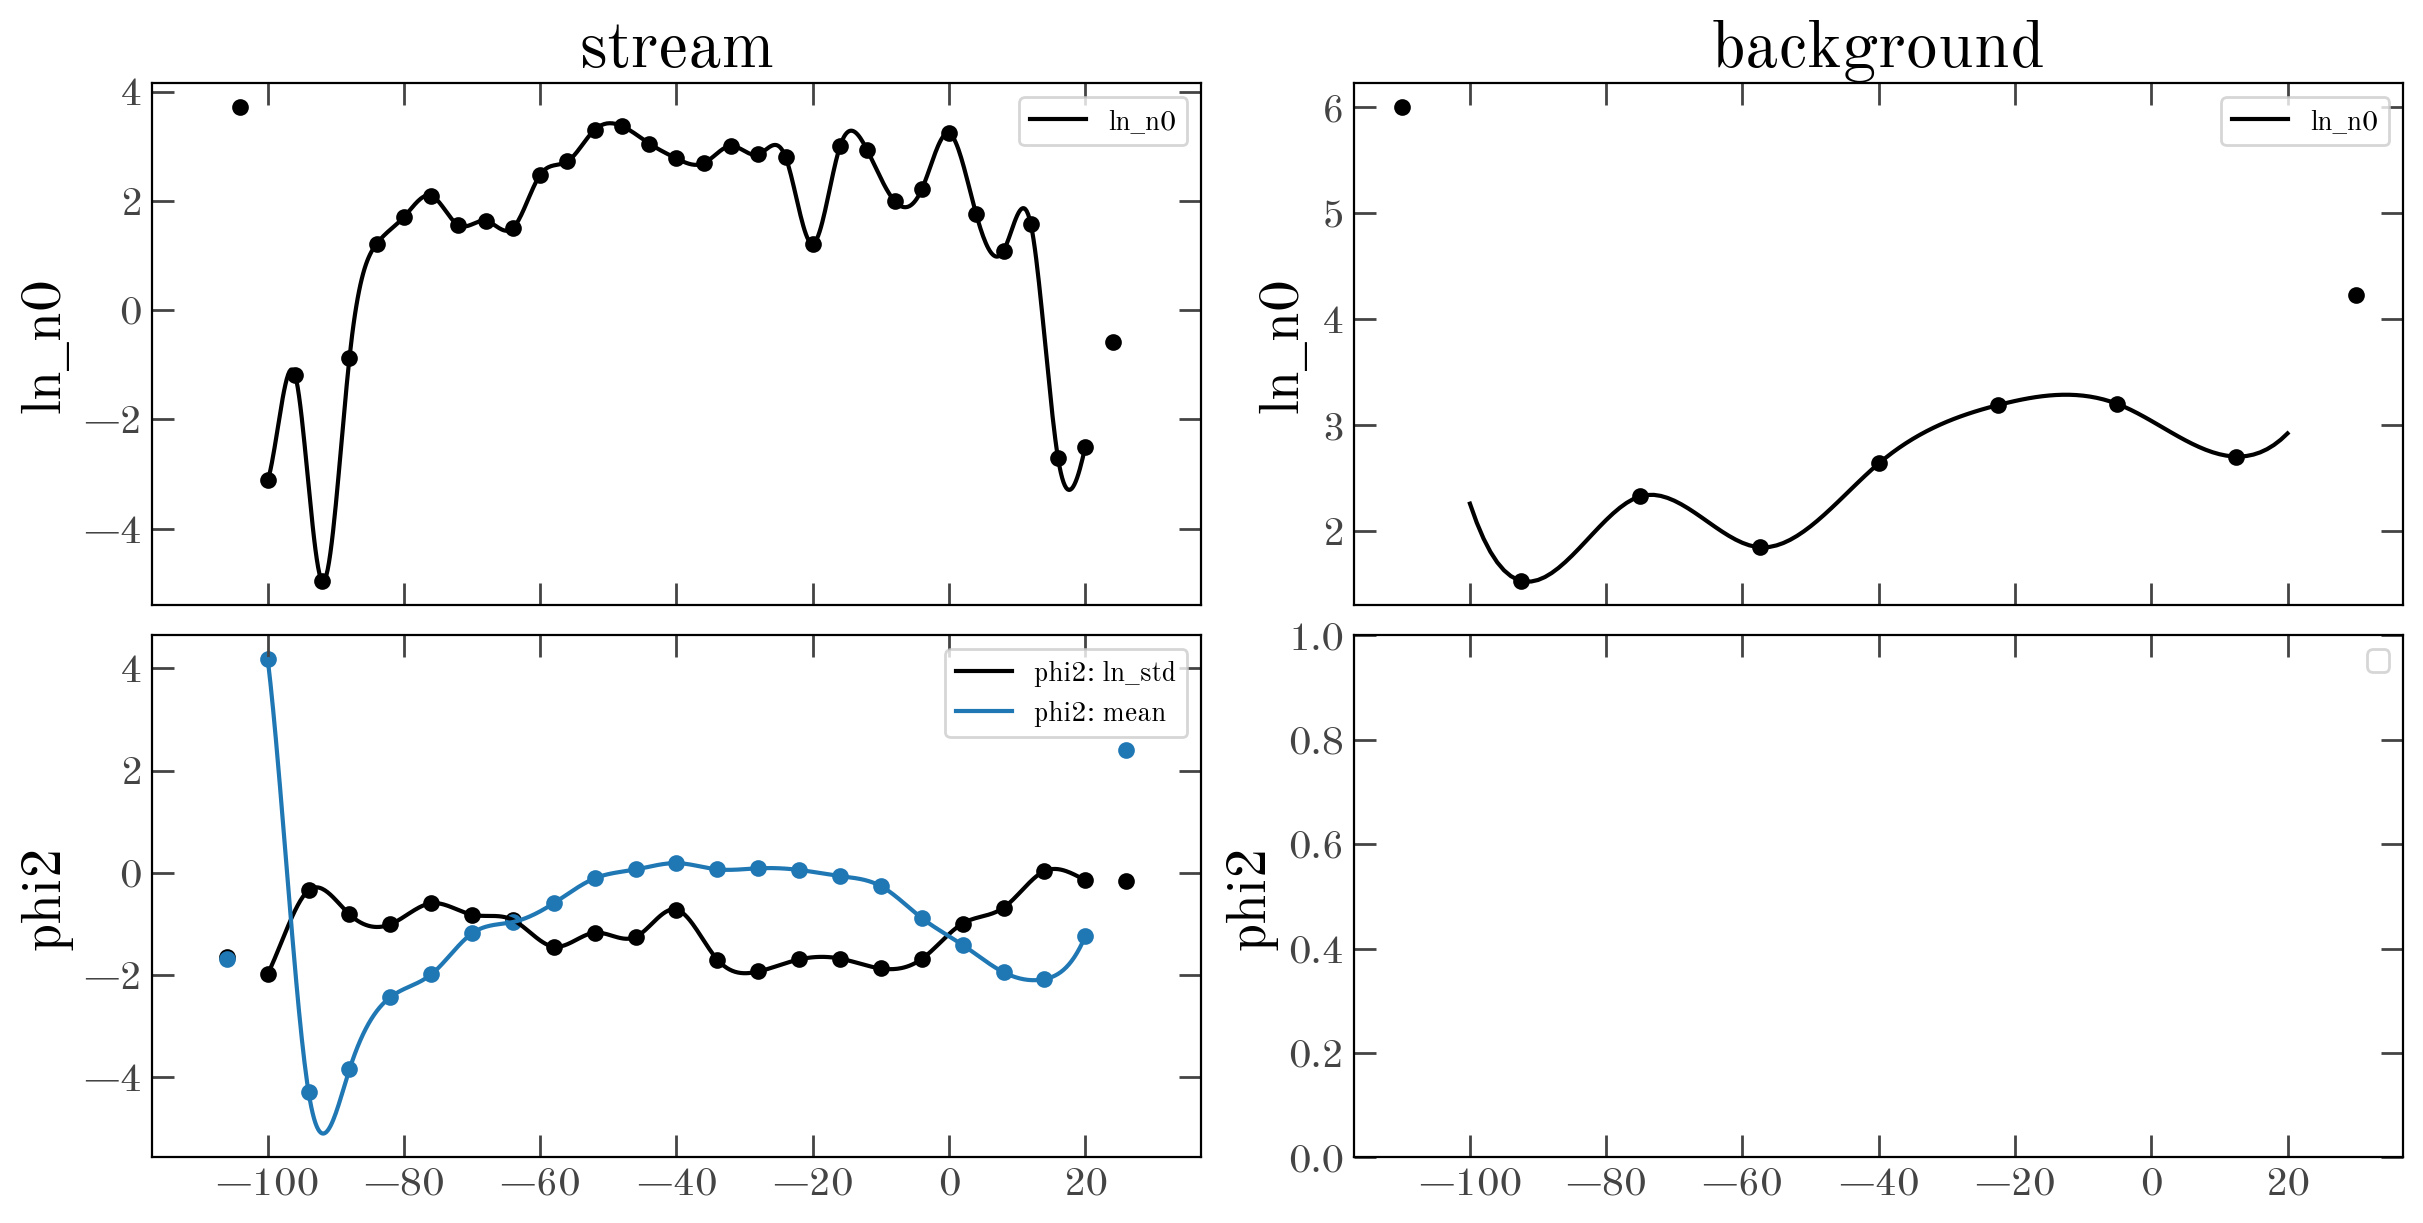

In [35]:
sample_mixture.plot_knots()